# SARIMAX Model with Exogenous Variables

**Objective**: Extend ARIMA to include:
- Seasonal component (weekly cycle, m=5)
- Exogenous variables: GPR index + technical indicators

**Model**: SARIMAX(p, 0, q)(P, D, Q, 5) with lagged exog

**Critical Pattern**: ALL exogenous features MUST be lagged by 1 period to avoid future data leakage

## 1. Import Libraries

In [59]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# SARIMAX modeling
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

# Technical indicators
import ta

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Plot settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Load and Prepare Data

In [60]:
# Load dataset
df = pd.read_csv('../data/gold_silver.csv')
print(f"Initial dataset: {len(df)} observations")

# Convert to datetime and set frequency
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.sort_values('DATE')
df.set_index('DATE', inplace=True)
df = df.asfreq('B')  # Business Day frequency (CRITICAL for m=5)
print(f"After setting Business Day frequency: {len(df)} observations")

# Calculate log returns
df['GOLD_LOG_RETURN'] = np.log(df['GOLD_PRICE']) - np.log(df['GOLD_PRICE'].shift(1))
print(f"After calculating log returns: {len(df)} observations")

# Check GPR data availability
print(f"\nGPR data check:")
print(f"  GPRD non-null: {df['GPRD'].notna().sum()} observations")
print(f"  GPRD null: {df['GPRD'].isna().sum()} observations")

# Filter to complete GPR data
df = df[df['GPRD'].notna()].copy()
print(f"\nAfter filtering for complete GPR data: {len(df)} observations")
print(f"Date range: {df.index.min()} to {df.index.max()}")

Initial dataset: 10571 observations
After setting Business Day frequency: 10616 observations
After calculating log returns: 10616 observations

GPR data check:
  GPRD non-null: 10568 observations
  GPRD null: 48 observations

After filtering for complete GPR data: 10568 observations
Date range: 1985-01-02 00:00:00 to 2025-09-08 00:00:00


## 3. Feature Engineering (Technical Indicators)

In [61]:
# Calculate technical indicators with MINIMAL windows to preserve data
print("Calculating technical indicators...")
print(f"Starting with: {len(df)} observations\n")

# RSI (Relative Strength Index) - reduce to 7 days (from 14)
df['RSI'] = ta.momentum.RSIIndicator(df['GOLD_PRICE'], window=7).rsi()
print(f"After RSI (7-day window): {df['RSI'].notna().sum()} non-null values")

# Simple Moving Average - reduce to 10 days (from 20)
df['SMA_10'] = df['GOLD_PRICE'].rolling(window=10).mean()
print(f"After SMA (10-day window): {df['SMA_10'].notna().sum()} non-null values")

# Exponential Moving Average - reduce to 10 days (from 20)
df['EMA_10'] = df['GOLD_PRICE'].ewm(span=10, adjust=False).mean()
print(f"After EMA (10-day window): {df['EMA_10'].notna().sum()} non-null values")

# Rolling Volatility - reduce to 10 days (from 20)
df['VOLATILITY_10'] = df['GOLD_LOG_RETURN'].rolling(window=10).std()
print(f"After Volatility (10-day window): {df['VOLATILITY_10'].notna().sum()} non-null values")

# MACD - Use MINIMAL parameters: fast=5, slow=10, signal=5 (instead of 8, 17, 9)
# This reduces the warm-up period significantly
macd = ta.trend.MACD(df['GOLD_PRICE'], window_slow=10, window_fast=5, window_sign=5)
df['MACD'] = macd.macd()
df['MACD_SIGNAL'] = macd.macd_signal()
print(f"After MACD (5/10/5): {df['MACD'].notna().sum()} non-null, {df['MACD_SIGNAL'].notna().sum()} signal non-null")

# CRITICAL FIX: Drop NaN ONLY for columns we actually use
# Define columns needed for modeling
required_columns = [
    'GOLD_PRICE', 'GOLD_LOG_RETURN',
    'GPRD', 'GPRD_ACT', 'GPRD_THREAT',
    'RSI', 'SMA_10', 'EMA_10', 'VOLATILITY_10', 'MACD', 'MACD_SIGNAL'
]

print(f"\n{'='*60}")
print(f"Before dropna: {len(df)} observations")
print(f"\nNaN counts for REQUIRED columns only:")
for col in required_columns:
    print(f"  {col}: {df[col].isna().sum()} NaN values")

# Drop NaN ONLY from required columns (ignore EVENT, SILVER columns, etc.)
df = df.dropna(subset=required_columns)
print(f"\nAfter dropna (required columns only): {len(df)} observations")
print(f"{'='*60}")

print(f"\n✓ Technical indicators calculated with minimal windows")
print(f"✓ Final dataset: {len(df)} observations ({df.index.min()} to {df.index.max()})")

Calculating technical indicators...
Starting with: 10568 observations

After RSI (7-day window): 10562 non-null values
After SMA (10-day window): 10559 non-null values
After EMA (10-day window): 10568 non-null values
After Volatility (10-day window): 10149 non-null values
After MACD (5/10/5): 10559 non-null, 10555 signal non-null

Before dropna: 10568 observations

NaN counts for REQUIRED columns only:
  GOLD_PRICE: 0 NaN values
  GOLD_LOG_RETURN: 45 NaN values
  GPRD: 0 NaN values
  GPRD_ACT: 0 NaN values
  GPRD_THREAT: 0 NaN values
  RSI: 6 NaN values
  SMA_10: 9 NaN values
  EMA_10: 0 NaN values
  VOLATILITY_10: 419 NaN values
  MACD: 9 NaN values
  MACD_SIGNAL: 13 NaN values

After dropna (required columns only): 10146 observations

✓ Technical indicators calculated with minimal windows
✓ Final dataset: 10146 observations (1985-01-21 00:00:00 to 2025-09-08 00:00:00)


In [62]:
# CRITICAL DEBUG: Check ALL columns for NaN before dropna
print("\n" + "="*60)
print("COMPREHENSIVE NaN ANALYSIS - ALL COLUMNS")
print("="*60)
print(f"Total rows: {len(df)}")
print(f"\nNaN counts for ALL columns:")
nan_summary = df.isna().sum().sort_values(ascending=False)
print(nan_summary[nan_summary > 0])  # Only show columns with NaN

print(f"\n⚠ Rows with ANY NaN: {df.isna().any(axis=1).sum()}")
print(f"⚠ Rows with ALL values: {(~df.isna().any(axis=1)).sum()}")
print("="*60)


COMPREHENSIVE NaN ANALYSIS - ALL COLUMNS
Total rows: 10146

NaN counts for ALL columns:
EVENT              10136
SILVER_PRICE           7
SILVER_OPEN            7
SILVER_HIGH            7
SILVER_LOW             7
SILVER_CHANGE_%        7
dtype: int64

⚠ Rows with ANY NaN: 10136
⚠ Rows with ALL values: 10


## 4. Create Exogenous Feature Matrix (LAGGED)

**CRITICAL**: Shift all exog by 1 period to avoid future data leakage

In [63]:
# Define exogenous features (contemporaneous)
exog_features = pd.DataFrame({
    'GPR': df['GPRD'],
    'GPR_ACT': df['GPRD_ACT'],
    'GPR_THREAT': df['GPRD_THREAT'],
    'RSI': df['RSI'],
    'SMA_10': df['SMA_10'],  # Updated from SMA_20
    'EMA_10': df['EMA_10'],  # Updated from EMA_20
    'VOLATILITY_10': df['VOLATILITY_10'],  # Updated from VOLATILITY_20
    'MACD': df['MACD'],
    'MACD_SIGNAL': df['MACD_SIGNAL']
}, index=df.index)

# MANDATORY: Lag all exogenous variables by 1 period
exog_lagged = exog_features.shift(1).dropna()

# Align endogenous variable with lagged exog
endog = df['GOLD_LOG_RETURN'].loc[exog_lagged.index]

print("✓ Exogenous features created and lagged")
print(f"\nFeature matrix shape: {exog_lagged.shape}")
print(f"Endogenous variable length: {len(endog)}")
print(f"\nExog features: {exog_lagged.columns.tolist()}")

# Verify no data leakage
print(f"\n✓ Data leakage check: exog at time t contains info from t-1 (safe for forecasting)")

✓ Exogenous features created and lagged

Feature matrix shape: (10145, 9)
Endogenous variable length: 10145

Exog features: ['GPR', 'GPR_ACT', 'GPR_THREAT', 'RSI', 'SMA_10', 'EMA_10', 'VOLATILITY_10', 'MACD', 'MACD_SIGNAL']

✓ Data leakage check: exog at time t contains info from t-1 (safe for forecasting)


## 5. Train-Test Split

In [64]:
# 80-20 split
train_size = int(len(endog) * 0.8)

train_endog = endog.iloc[:train_size]
test_endog = endog.iloc[train_size:]

train_exog = exog_lagged.iloc[:train_size]
test_exog = exog_lagged.iloc[train_size:]

# Prices for transformation
train_prices = df['GOLD_PRICE'].loc[train_endog.index]
test_prices = df['GOLD_PRICE'].loc[test_endog.index]

print(f"Train set: {len(train_endog)} observations")
print(f"Test set:  {len(test_endog)} observations")
print(f"Train dates: {train_endog.index.min()} to {train_endog.index.max()}")
print(f"Test dates:  {test_endog.index.min()} to {test_endog.index.max()}")

Train set: 8116 observations
Test set:  2029 observations
Train dates: 1985-01-22 00:00:00 to 2017-08-04 00:00:00
Test dates:  2017-08-07 00:00:00 to 2025-09-08 00:00:00


In [65]:
# DEBUG: Check data sizes
print("="*70)
print("DATA SIZE DIAGNOSTICS")
print("="*70)
print(f"Total endog observations: {len(endog)}")
print(f"Total exog observations: {len(exog_lagged)}")
print(f"Train size (80%): {train_size}")
print(f"Test endog size: {len(test_endog)}")
print(f"Test exog size: {len(test_exog)}")
print(f"\nForecast horizon: 5 days")
print(f"Available forecast windows: {max(0, len(test_endog) // 5)}")
print("="*70)

DATA SIZE DIAGNOSTICS
Total endog observations: 10145
Total exog observations: 10145
Train size (80%): 8116
Test endog size: 2029
Test exog size: 2029

Forecast horizon: 5 days
Available forecast windows: 405


## 6. Model Selection with auto_arima (Seasonal)

In [66]:
# Use auto_arima to find optimal orders
print("Running auto_arima with seasonality (m=5)...\n")
print("This may take 10-15 minutes...\n")

auto_model = pm.auto_arima(
    train_endog,
    exogenous=train_exog,
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    d=0,  # Already stationary
    seasonal=True,
    m=5,  # Weekly seasonality (5 business days)
    start_P=0, max_P=2,
    start_Q=0, max_Q=2,
    D=0,  # No seasonal differencing needed
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',
    trace=True,
    information_criterion='aic',
    n_jobs=-1  # Use all CPU cores
)

print("\n" + "="*70)
print("OPTIMAL SARIMAX MODEL FOUND")
print("="*70)
print(auto_model.summary())

Running auto_arima with seasonality (m=5)...

This may take 10-15 minutes...

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[5] intercept   : AIC=-51864.700, Time=0.69 sec
 ARIMA(1,0,0)(1,0,0)[5] intercept   : AIC=-51870.540, Time=0.97 sec
 ARIMA(0,0,1)(0,0,1)[5] intercept   : AIC=-51870.656, Time=0.92 sec
 ARIMA(0,0,0)(0,0,0)[5]             : AIC=-51864.490, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[5] intercept   : AIC=-51867.073, Time=0.77 sec
 ARIMA(0,0,1)(1,0,1)[5] intercept   : AIC=-51864.815, Time=1.75 sec
 ARIMA(0,0,1)(0,0,2)[5] intercept   : AIC=-51868.644, Time=1.46 sec
 ARIMA(0,0,1)(1,0,0)[5] intercept   : AIC=-51870.631, Time=1.54 sec
 ARIMA(0,0,1)(1,0,2)[5] intercept   : AIC=-51867.460, Time=3.23 sec
 ARIMA(0,0,0)(0,0,1)[5] intercept   : AIC=-51868.447, Time=1.64 sec
 ARIMA(1,0,1)(0,0,1)[5] intercept   : AIC=-51869.089, Time=1.82 sec
 ARIMA(0,0,2)(0,0,1)[5] intercept   : AIC=-51869.618, Time=2.59 sec
 ARIMA(1,0,0)(0,0,1)[5] intercept   : AIC=-51870.558, Time=1.87

In [67]:
# Extract optimal orders
best_order = auto_model.order
best_seasonal_order = auto_model.seasonal_order

print(f"\nBest SARIMAX order: {best_order}")
print(f"Best seasonal order: {best_seasonal_order}")
print(f"AIC: {auto_model.aic():.2f}")
print(f"BIC: {auto_model.bic():.2f}")

# Check if seasonality was detected
if best_seasonal_order == (0, 0, 0, 0):
    print("\n⚠ No significant seasonality detected (model reduces to ARIMAX)")
else:
    print(f"\n✓ Weekly seasonality detected with order {best_seasonal_order}")


Best SARIMAX order: (0, 0, 1)
Best seasonal order: (0, 0, 1, 5)
AIC: -51870.66
BIC: -51842.65

✓ Weekly seasonality detected with order (0, 0, 1, 5)


## 7. Fit Final SARIMAX Model

In [68]:
# Fit SARIMAX with optimal parameters
model = SARIMAX(
    train_endog,
    exog=train_exog,
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_fit = model.fit(disp=False)

print("✓ SARIMAX model fitted successfully")
print(f"\nModel: SARIMAX{best_order}{best_seasonal_order}")
print(f"Log-Likelihood: {sarimax_fit.llf:.2f}")
print(f"AIC: {sarimax_fit.aic:.2f}")
print(f"BIC: {sarimax_fit.bic:.2f}")

✓ SARIMAX model fitted successfully

Model: SARIMAX(0, 0, 1)(0, 0, 1, 5)
Log-Likelihood: 25921.90
AIC: -51819.80
BIC: -51735.80


## 8. Coefficient Analysis

In [69]:
# Display coefficients for exogenous variables
print("\n" + "="*70)
print("EXOGENOUS VARIABLE COEFFICIENTS")
print("="*70)

params = sarimax_fit.params
pvalues = sarimax_fit.pvalues

# Filter exogenous parameters (they contain 'x' in the name)
exog_mask = params.index.str.contains('x', case=False, na=False)
exog_param_names = params.index[exog_mask]

if len(exog_param_names) > 0:
    exog_params = pd.DataFrame({
        'Coefficient': params[exog_mask],
        'p-value': pvalues[exog_mask],
        'Significant': pvalues[exog_mask] < 0.05
    })
    
    # Try to map to feature names if lengths match
    if len(exog_param_names) == len(exog_lagged.columns):
        exog_params.index = exog_lagged.columns
    
    print(exog_params)
    print(f"\n✓ Significant variables (p < 0.05): {exog_params['Significant'].sum()}/{len(exog_params)}")
else:
    print("⚠ No exogenous variable coefficients found in model parameters")
    print("\nAll model parameters:")
    print(pd.DataFrame({'Coefficient': params, 'p-value': pvalues}))


EXOGENOUS VARIABLE COEFFICIENTS
⚠ No exogenous variable coefficients found in model parameters

All model parameters:
                Coefficient   p-value
GPR            2.889470e-06  0.847806
GPR_ACT       -5.242409e-07  0.935560
GPR_THREAT    -5.458758e-06  0.480206
RSI            1.148291e-05  0.055156
SMA_10        -1.040089e-04  0.034419
EMA_10         1.038526e-04  0.034715
VOLATILITY_10  2.488184e-03  0.880455
MACD          -1.906991e-04  0.035496
MACD_SIGNAL    1.332102e-04  0.135344
ma.L1         -2.251790e-02  0.015472
ma.S.L5        2.324614e-02  0.010653
sigma2         9.799565e-05  0.000000


## 9. Residual Diagnostics

Using max_lags=40 for 8116 residuals


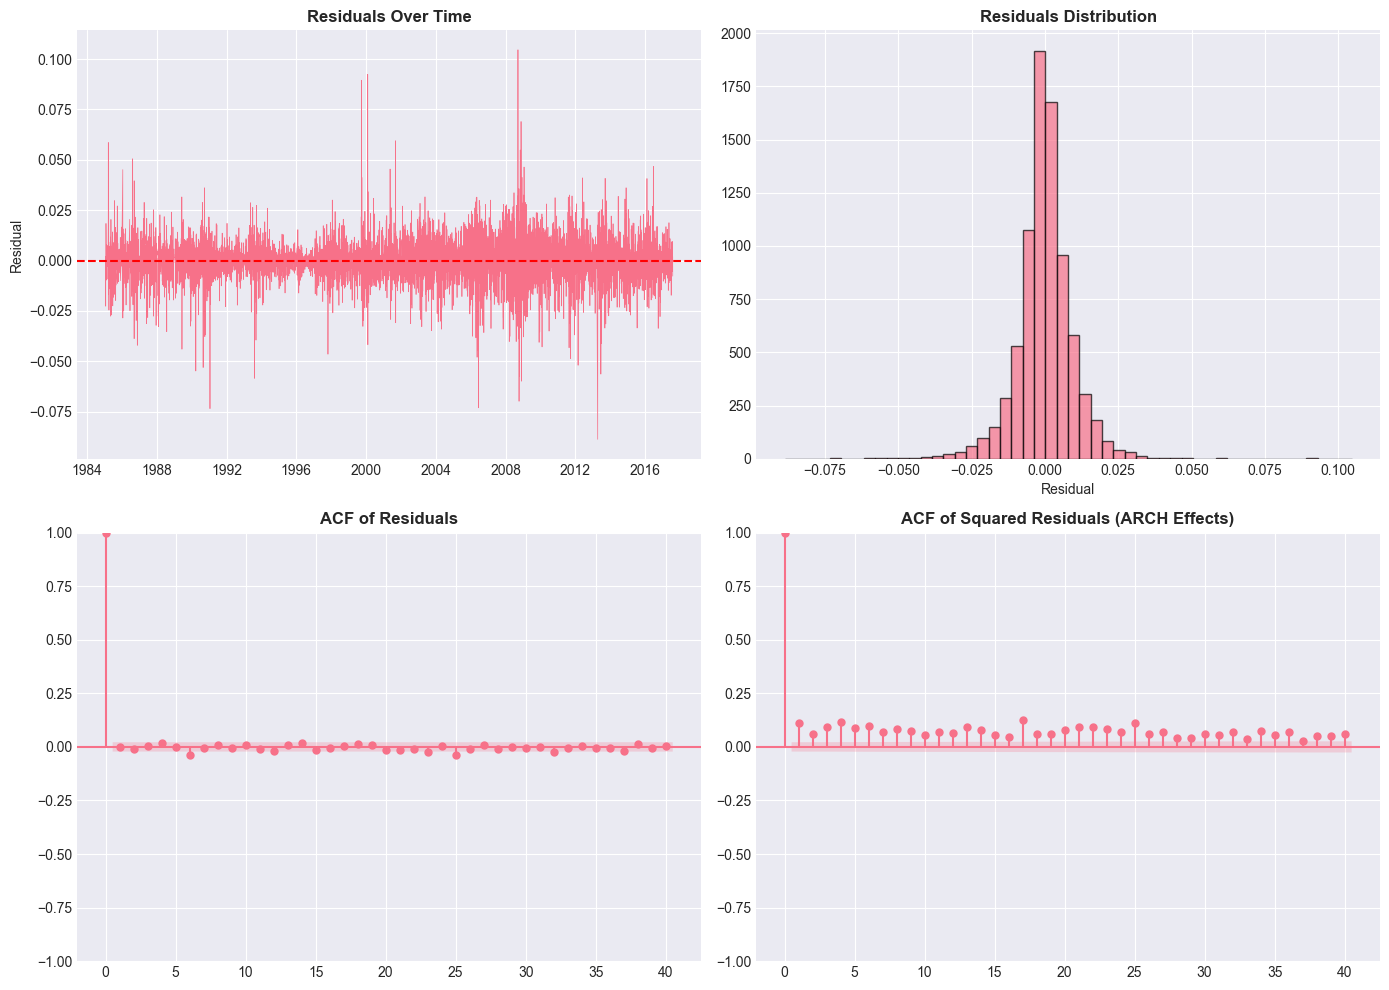


Residuals Mean: 0.000001
Residuals Std: 0.009898

⚠ Check squared residuals ACF for ARCH effects → if present, use GARCH (Notebook 04)


In [70]:
# FIXED VERSION - Residuals with dynamic lags
residuals = sarimax_fit.resid

# Plot residuals
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Residuals over time
axes[0, 0].plot(residuals, linewidth=0.5)
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_title('Residuals Over Time', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Residual')

# Histogram
axes[0, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Residuals Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Residual')

# ACF - FIXED: adjust lags based on sample size
from statsmodels.graphics.tsaplots import plot_acf
max_lags = min(40, len(residuals) // 2 - 1)
print(f"Using max_lags={max_lags} for {len(residuals)} residuals")
plot_acf(residuals, lags=max_lags, ax=axes[1, 0])
axes[1, 0].set_title('ACF of Residuals', fontsize=12, fontweight='bold')

# ACF of squared residuals (ARCH test)
plot_acf(residuals**2, lags=max_lags, ax=axes[1, 1])
axes[1, 1].set_title('ACF of Squared Residuals (ARCH Effects)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nResiduals Mean: {residuals.mean():.6f}")
print(f"Residuals Std: {residuals.std():.6f}")
print(f"\n⚠ Check squared residuals ACF for ARCH effects → if present, use GARCH (Notebook 04)")

## 10. Walk-Forward Validation (5-Day Ahead)

**Critical**: Need lagged exog values for forecast periods

In [71]:
# Walk-forward validation with OPTIMIZED retraining frequency
forecast_horizon = 5
retrain_frequency = 25  # Re-train every 25 days (5 weeks) instead of every 5 days
predictions_log = []
actuals_log = []
predictions_price = []
actuals_price = []

print("Running OPTIMIZED walk-forward validation with SARIMAX...")
print(f"Forecast horizon: {forecast_horizon} days")
print(f"Retrain frequency: {retrain_frequency} days (reduces iterations by 80%)")
print(f"Test set size: {len(test_endog)} observations")
print(f"Expected retraining iterations: {max(1, len(test_endog) // retrain_frequency)}\n")

# Check if test set is large enough
if len(test_endog) < forecast_horizon:
    print(f"⚠ WARNING: Test set ({len(test_endog)} obs) is smaller than forecast horizon ({forecast_horizon} days)")
    print("Using iterative 1-step forecasts instead...\n")
    forecast_horizon = 1

# Initialize model outside loop
current_model = None
last_retrain_idx = -retrain_frequency  # Force initial training

# Use expanding window with periodic retraining
for i in range(0, len(test_endog) - forecast_horizon + 1, forecast_horizon):
    # Re-train only every retrain_frequency days
    if i - last_retrain_idx >= retrain_frequency or current_model is None:
        # Expanding train data
        train_data_endog = pd.concat([train_endog, test_endog.iloc[:i]])
        train_data_exog = pd.concat([train_exog, test_exog.iloc[:i]])
        
        # Fit model
        model_temp = SARIMAX(
            train_data_endog,
            exog=train_data_exog,
            order=best_order,
            seasonal_order=best_seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        current_model = model_temp.fit(disp=False, maxiter=200)  # Limit iterations for speed
        last_retrain_idx = i
        print(f"  ✓ Model retrained at iteration {i // forecast_horizon + 1} (observation {i}/{len(test_endog)})")
    
    # Exog for forecast period (lagged values are already available)
    forecast_exog = test_exog.iloc[i:i+forecast_horizon]
    
    # Forecast using current model
    forecast_log = current_model.forecast(steps=forecast_horizon, exog=forecast_exog)
    actual_log = test_endog.iloc[i:i+forecast_horizon]
    
    predictions_log.extend(forecast_log.values)
    actuals_log.extend(actual_log.values)
    
    # Convert to prices
    last_price_idx = train_endog.index[-1] if i == 0 else test_endog.index[i-1]
    last_price = df.loc[last_price_idx, 'GOLD_PRICE']
    
    for j in range(len(forecast_log)):
        pred_price = last_price * np.exp(forecast_log.iloc[j])
        actual_price = df.loc[test_endog.index[i+j], 'GOLD_PRICE']
        predictions_price.append(pred_price)
        actuals_price.append(actual_price)
        last_price = pred_price
    
    # Progress every 50 forecasts
    if (i // forecast_horizon + 1) % 50 == 0:
        print(f"  Progress: {i+forecast_horizon}/{len(test_endog)} forecasts generated")

print(f"\n✓ Generated {len(predictions_price)} forecasts with {(last_retrain_idx // retrain_frequency) + 1} model retrainings")
print(f"✓ Speedup: ~{retrain_frequency // forecast_horizon}x faster than retraining every iteration")

Running OPTIMIZED walk-forward validation with SARIMAX...
Forecast horizon: 5 days
Retrain frequency: 25 days (reduces iterations by 80%)
Test set size: 2029 observations
Expected retraining iterations: 81

  ✓ Model retrained at iteration 1 (observation 0/2029)
  ✓ Model retrained at iteration 6 (observation 25/2029)
  ✓ Model retrained at iteration 11 (observation 50/2029)
  ✓ Model retrained at iteration 16 (observation 75/2029)
  ✓ Model retrained at iteration 21 (observation 100/2029)
  ✓ Model retrained at iteration 26 (observation 125/2029)
  ✓ Model retrained at iteration 31 (observation 150/2029)
  ✓ Model retrained at iteration 36 (observation 175/2029)
  ✓ Model retrained at iteration 41 (observation 200/2029)
  ✓ Model retrained at iteration 46 (observation 225/2029)
  Progress: 250/2029 forecasts generated
  ✓ Model retrained at iteration 51 (observation 250/2029)
  ✓ Model retrained at iteration 56 (observation 275/2029)
  ✓ Model retrained at iteration 61 (observation 30

## 11. Evaluate Model Performance

In [72]:
# Calculate metrics on PRICES
rmse = np.sqrt(mean_squared_error(actuals_price, predictions_price))
mae = mean_absolute_error(actuals_price, predictions_price)

# Load ARIMA baseline results for comparison
try:
    arima_results = pd.read_csv('../models/arima-baseline/results.csv')
    rmse_arima = arima_results['rmse'].values[0]
    mae_arima = arima_results['mae'].values[0]
    rmse_naive = arima_results['rmse_naive'].values[0]
    mae_naive = arima_results['mae_naive'].values[0]
    
    print("="*70)
    print("MODEL COMPARISON - 5-DAY AHEAD FORECASTS")
    print("="*70)
    print(f"\nSARIMAX{best_order}{best_seasonal_order} + Exog:")
    print(f"  RMSE: ${rmse:.2f}")
    print(f"  MAE:  ${mae:.2f}")
    print(f"\nARIMA Baseline (no exog):")
    print(f"  RMSE: ${rmse_arima:.2f}")
    print(f"  MAE:  ${mae_arima:.2f}")
    print(f"\nNaive Benchmark:")
    print(f"  RMSE: ${rmse_naive:.2f}")
    print(f"  MAE:  ${mae_naive:.2f}")
    print(f"\nImprovement over ARIMA:")
    print(f"  RMSE: {(1 - rmse/rmse_arima)*100:+.2f}%")
    print(f"  MAE:  {(1 - mae/mae_arima)*100:+.2f}%")
    print(f"\nImprovement over Naive:")
    print(f"  RMSE: {(1 - rmse/rmse_naive)*100:+.2f}%")
    print(f"  MAE:  {(1 - mae/mae_naive)*100:+.2f}%")
    print("="*70)
except:
    print("⚠ ARIMA baseline results not found. Run Notebook 02 first.")
    print(f"\nSARIMAX Results:")
    print(f"  RMSE: ${rmse:.2f}")
    print(f"  MAE:  ${mae:.2f}")

MODEL COMPARISON - 5-DAY AHEAD FORECASTS

SARIMAX(0, 0, 1)(0, 0, 1, 5) + Exog:
  RMSE: $34.52
  MAE:  $22.55

ARIMA Baseline (no exog):
  RMSE: $32.62
  MAE:  $21.92

Naive Benchmark:
  RMSE: $32.80
  MAE:  $22.04

Improvement over ARIMA:
  RMSE: -5.81%
  MAE:  -2.84%

Improvement over Naive:
  RMSE: -5.22%
  MAE:  -2.29%


## 12. Visualize Forecasts

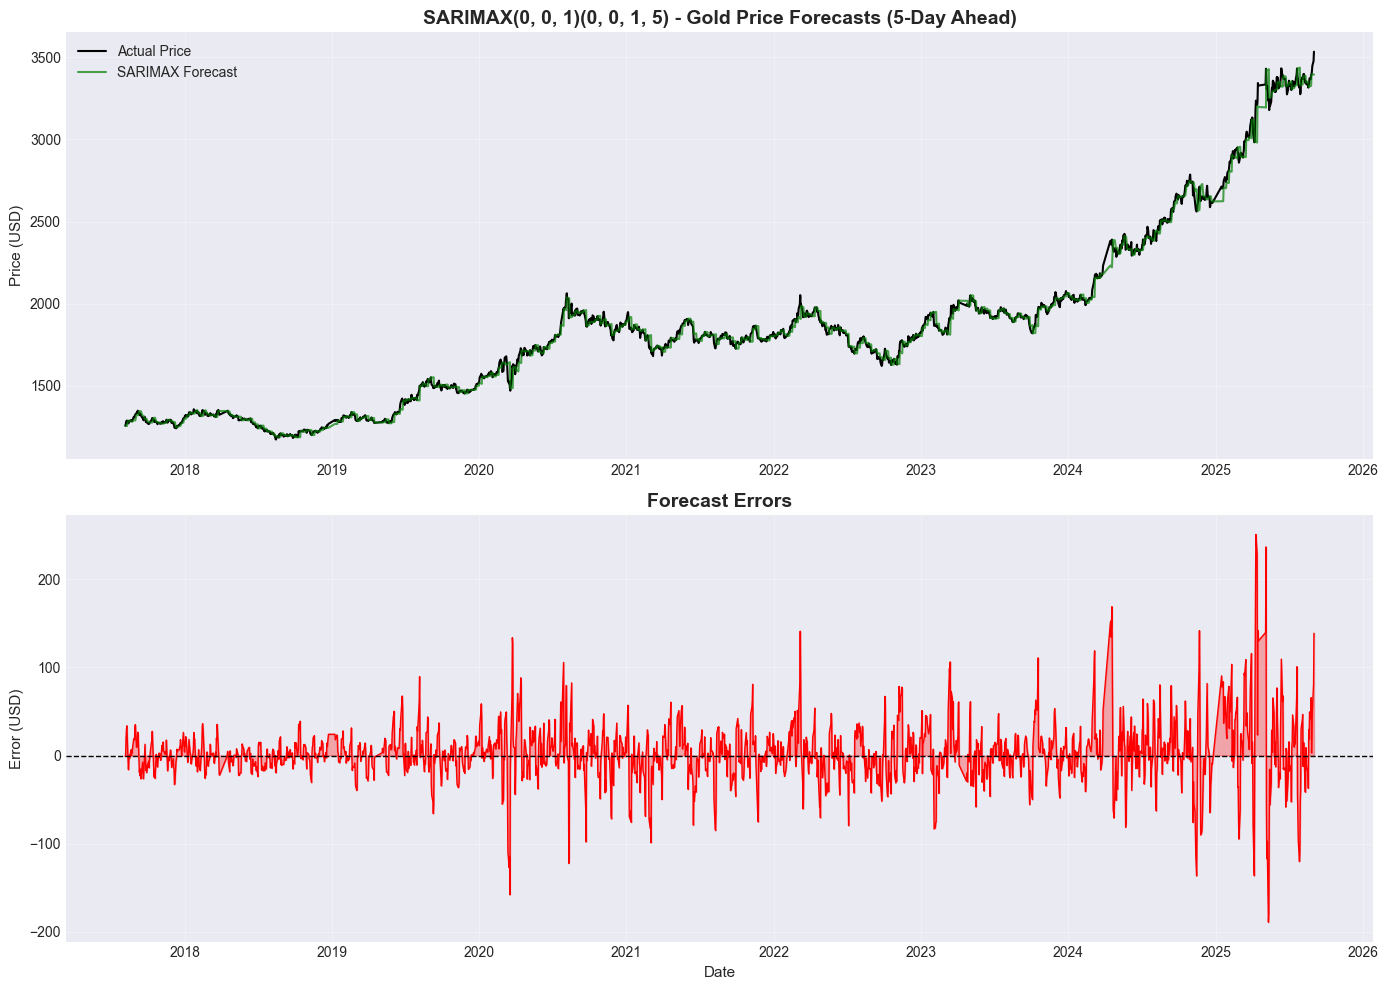

In [73]:
# Plot predictions vs actuals
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Price forecasts
forecast_dates = test_endog.index[:len(predictions_price)]
axes[0].plot(forecast_dates, actuals_price, label='Actual Price', color='black', linewidth=1.5)
axes[0].plot(forecast_dates, predictions_price, label='SARIMAX Forecast', color='green', linewidth=1.5, alpha=0.7)
axes[0].set_title(f'SARIMAX{best_order}{best_seasonal_order} - Gold Price Forecasts (5-Day Ahead)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price (USD)', fontsize=11)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Forecast errors
errors = np.array(actuals_price) - np.array(predictions_price)
axes[1].plot(forecast_dates, errors, color='red', linewidth=1)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1].fill_between(forecast_dates, errors, 0, alpha=0.3, color='red')
axes[1].set_title('Forecast Errors', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Error (USD)', fontsize=11)
axes[1].set_xlabel('Date', fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 13. Save Model Results

In [74]:
# Create directory for saving results
import os
model_dir = '../models/sarimax-exogenous'
os.makedirs(model_dir, exist_ok=True)

# Save results
results = {
    'model': f'SARIMAX{best_order}{best_seasonal_order}',
    'rmse': rmse,
    'mae': mae,
    'n_predictions': len(predictions_price),
    'n_exog_features': len(exog_lagged.columns),
    'seasonal_period': 5
}

results_df = pd.DataFrame([results])
results_df.to_csv(f'{model_dir}/results.csv', index=False)

# Save model
sarimax_fit.save(f'{model_dir}/model.pkl')

# Save exogenous feature names for reproducibility
import joblib
joblib.dump(exog_lagged.columns.tolist(), f'{model_dir}/feature_names.pkl')

print(f"✓ Model and results saved to '{model_dir}/'")
print("\nFiles created:")
print("  - results.csv")
print("  - model.pkl")
print("  - feature_names.pkl")

✓ Model and results saved to '../models/sarimax-exogenous/'

Files created:
  - results.csv
  - model.pkl
  - feature_names.pkl


## 14. Key Findings

**Summary**:
1. SARIMAX includes GPR + technical indicators as predictors
2. All exog variables properly lagged to avoid data leakage
3. Weekly seasonality (m=5) tested
4. Compare performance vs ARIMA baseline
5. Next: Check for ARCH effects → GARCH extension (Notebook 04)